### Notice
#### The original code for GP-VAE can be found in the author's repository. https://github.com/abudesai/timeVAE

### Library import

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from Libs.TIMEVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from Libs.TIMEVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from Libs.TIMEVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
import Libs.TIMEVAE.utils
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from argparse import ArgumentParser


## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))     



### Parameter setting

In [2]:
SigType ='rawART'
### Model related parameters
LatDim = 10

file_pref = 'TimeVae_Lat'+str(LatDim)+'_' 
Outdir = './Results/'

In [3]:
TrData = np.load('../Data/ProcessedData/Tr'+str(SigType)+'.npy').astype('float32')
ValData = np.load('../Data/ProcessedData/Val'+str(SigType)+'.npy').astype('float32')


TrDataFrame = tf.signal.frame(TrData, 50, 50).numpy()
ValDataFrame = tf.signal.frame(ValData, 50, 50).numpy()


In [5]:
# Load
vae = TimeVAE.load(Outdir, file_pref)

In [6]:
Pred = vae.predict(ValDataFrame, batch_size=1000, verbose=1).reshape(-1, 1000)

60/60 [==============================] - 2s 4ms/step


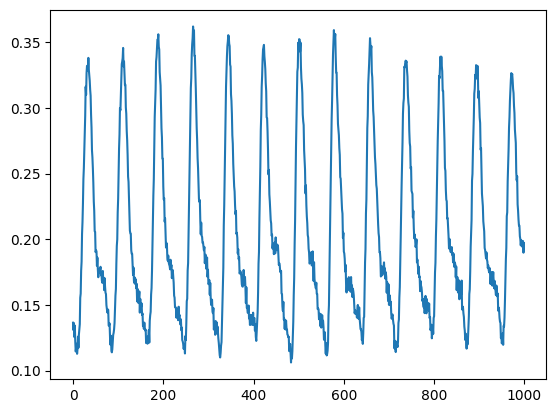

In [7]:
plt.plot(Pred[5])

In [8]:
# draw random prior samples
N_Exp= 200

# print("num_samples: ", num_samples)
samples = vae.get_prior_samples(num_samples=N_Exp).reshape(-1, 1000)

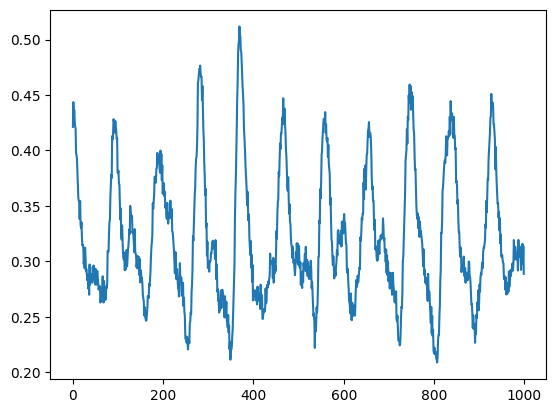

In [9]:
plt.plot(samples[5])

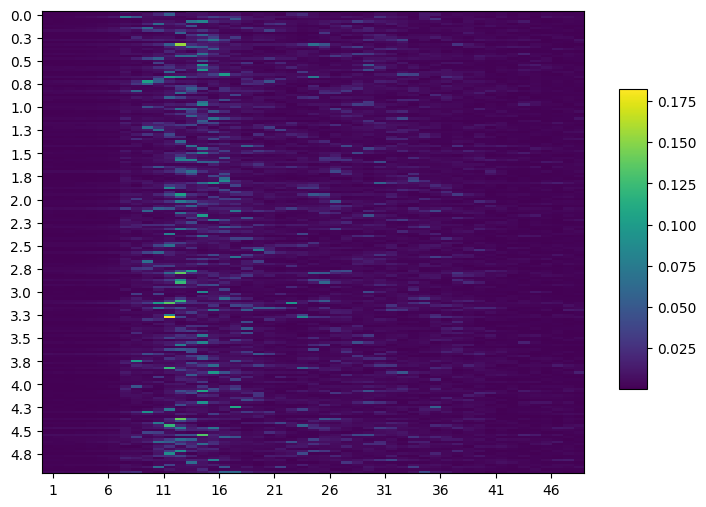

In [10]:
HalfLen = samples.shape[1]//2
FFTRes = np.abs(np.fft.fft(samples, axis=-1)[:, :HalfLen]) 
Amplitude_FcVar = FFTRes/HalfLen
Heatmap = Amplitude_FcVar[:, 1:51]



fig, ax = plt.subplots(figsize=(7,6))
cax = fig.add_axes([0.95, 0.25, 0.04, 0.5])

im = ax.imshow(Amplitude_FcVar[:, 1:50],  cmap='viridis', aspect='auto',interpolation='nearest') 
#ax.set(yticks=np.arange(1, 200)[::10], yticklabels=np.arange(1, 200)[::10]);
ax.set(yticks=np.arange(1, 200)[::10], yticklabels=np.round(np.linspace(1e-7, 0.05, N_Exp )[::10]*100, 1));
ax.set(xticks=np.arange(1, 50)[::5]-0.5, xticklabels=np.arange(1, 50)[::5]);

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()


# 'Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'YlOrBr', 'YlOrRd', 'YlGn'  
# 'coolwarm', 'BrBG', 'PRGn', 'PiYG', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral' viridis
# 'tab10', 'tab20', 'hls', 'husl', 'Paired', 'Set1', 'Set2', 'Set3'

#ytick_labels = np.linspace(1e-7, 0.05, N_Exp ).round(5).tolist()
#ytick_positions = np.arange(0, len(ytick_labels), 1)  # 라벨 중앙에 위치하도록 조정
#plt.yticks( ytick_labels)


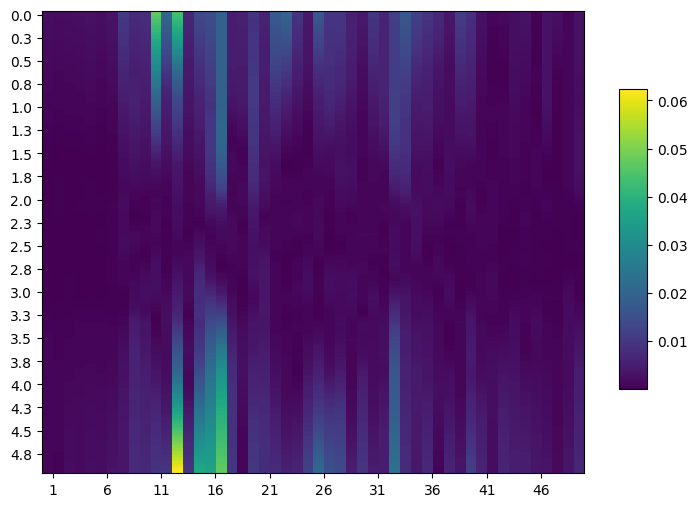

0.2062326449437685

In [11]:
Z_pred = np.linspace(-1.5, 1.5, N_Exp*LatDim).reshape(N_Exp, -1)

samples = vae.decoder.predict(Z_pred).reshape(-1, 1000)

HalfLen = samples.shape[1]//2
FFTRes = np.abs(np.fft.fft(samples, axis=-1)[:, :HalfLen]) 
Amplitude_FcVar = FFTRes/HalfLen
Heatmap = Amplitude_FcVar[:, 1:51]
Min = np.min(Heatmap, axis=1, keepdims=True)
Max = np.max(Heatmap, axis=1, keepdims=True)
NormHeatmap = (Heatmap - Min) / (Max - Min)

fig, ax = plt.subplots(figsize=(7,6))
cax = fig.add_axes([0.95, 0.25, 0.04, 0.5])

im = ax.imshow(Heatmap,  cmap='viridis', aspect='auto',interpolation='nearest') 
#ax.set(yticks=np.arange(1, 200)[::10], yticklabels=np.arange(1, 200)[::10]);
ax.set(yticks=np.arange(1, 200)[::10], yticklabels=np.round(np.linspace(1e-7, 0.05, N_Exp )[::10]*100, 1));
ax.set(xticks=np.arange(1, 50)[::5]-0.5, xticklabels=np.arange(1, 50)[::5]);

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

labels = np.argmax(Heatmap, axis=1)  # assign each point to a cluster
silhouette_avg = silhouette_score(Heatmap, labels)  # calculate silhouette score
silhouette_avg

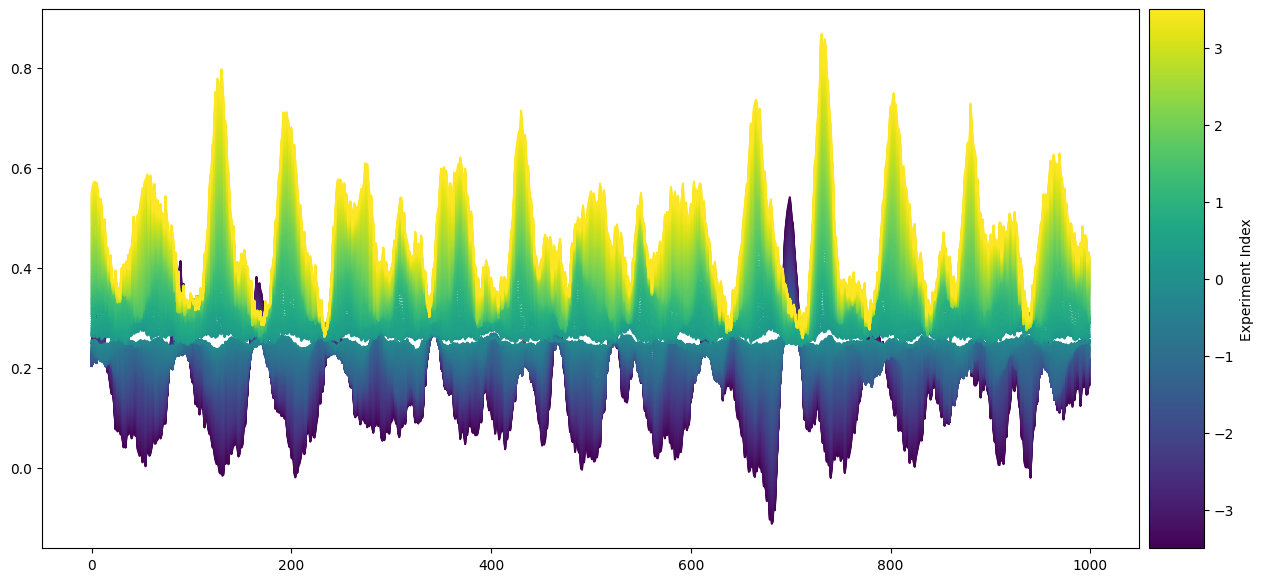

In [13]:
N_Exp = 200
MedCut = 0.1

Z_pred = np.linspace(-2., 2., N_Exp*LatDim).reshape(N_Exp, -1)
samples = vae.decoder.predict(Z_pred).reshape(-1, 1000)


# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Exp-1)
norm2 = plt.Normalize(-3.5, 3.5)


fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Exp):
    color = cmap(norm(i))
    #ax.plot(FeatGen[3][i], color=color)
    if np.mean(np.abs(Z_pred[i])) > MedCut:
        ax.plot(samples[i], color=color)
        #ax.plot(FeatGen[3][i], color=color)
        
# Create color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Experiment Index')

plt.show()

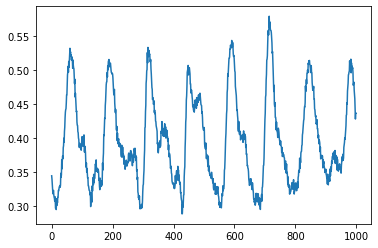

In [35]:
plt.plot(samples[50])

In [35]:
def KernelGen (SortedWindow, MinIdx, WindowSize):
    
    TotalSpace = WindowSize-1
    LeftSpaceSize = MinIdx - 0 
    RightSpaceSize = WindowSize-LeftSpaceSize-1
    InterIDX = 1


    LeftSide = []
    RightSide = []

    # Kernel generation
    while LeftSpaceSize>0 or RightSpaceSize>0:

        if LeftSpaceSize>0:
            LeftSide.append(SortedWindow[InterIDX])
            InterIDX += 1
            LeftSpaceSize -= 1

        if RightSpaceSize>0:
            RightSide.append(SortedWindow[InterIDX])
            InterIDX += 1
            RightSpaceSize -= 1

    Kernel = np.concatenate([LeftSide[::-1], [SortedWindow[0]], RightSide])    
    
    return Kernel



def MonotonDegree (Vec, WindowSize):
    
    AbsRhoList = []
    

    for i in range(len(Vec) - WindowSize+1):
        Window = Vec[i:i + WindowSize]

        # Create an ideal monotonic list based on the sorted vector
        SortedWindow = sorted(Window)

        SubRhos=[]
        # Compute Spearman's rho between Kernel and window
        for MinIdx in range(WindowSize):
            LeftSpaceSize = MinIdx - 0 

            Kernel = KernelGen(SortedWindow, MinIdx, WindowSize)
            #Kernel = sorted(Window)

            # Compute Spearman's rho
            SubRho = spearmanr(Window, Kernel)[0]

            # Appeding sub-Rho values
            SubRhos.append(abs(SubRho) * np.log(WindowSize) ) # log(WindowSize) : Weighting by increasing window size 
        AbsRhoList.append(max(SubRhos))


    return np.mean(AbsRhoList) 





In [36]:
N_Exp_ = 30
MaxIDX = np.argmax(np.mean(Heatmap, axis=0))
Vec =  Heatmap[:, MaxIDX]
MonotonDegree(Vec, MonoWinSize).round(4)

2.9109